In [191]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import numpy.random as random
from graphviz import Digraph

#### Code used for tracegraphs

In [192]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [193]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other): 
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other): 
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

### Using the tanh function for backpropagation 

In [194]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2x2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [195]:
o.backward()

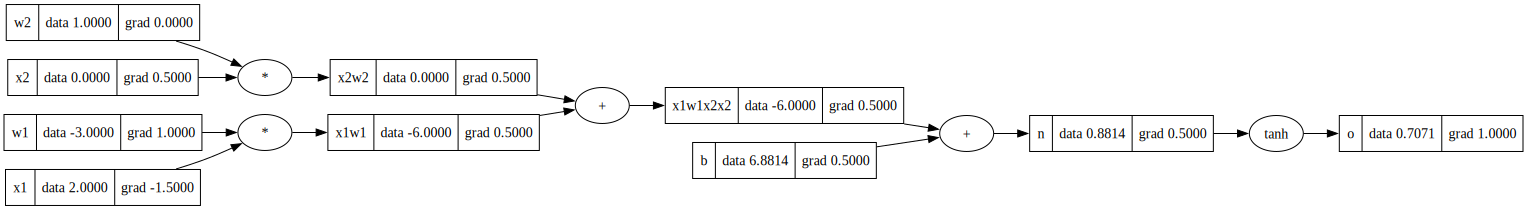

In [196]:
draw_dot(o)

### Breaking up tanh into smaller components

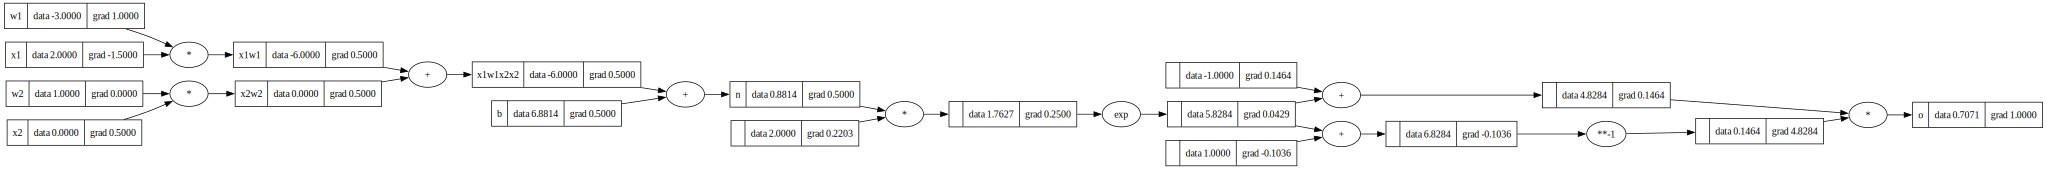

In [197]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2x2'

n = x1w1x2w2 + b; n.label='n'
#----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----
o.label='o'
o.backward()
draw_dot(o)

### Building a neuron

In [285]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x): 
        # w * x + b
        act = sum((wi * xi for wi, xi in  zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [286]:
x= [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7348242146403569)

In [287]:
n.parameters()

[Value(data=0.9800349677677094),
 Value(data=-0.5406118689151262),
 Value(data=0.3205294463987496),
 Value(data=-0.7270536711012168),
 Value(data=-0.6322717527153867),
 Value(data=0.4439697257009465),
 Value(data=0.23371943193329492),
 Value(data=-0.14625913660838163),
 Value(data=-0.9986646103590344),
 Value(data=0.9633213165759547),
 Value(data=-0.5565956764886464),
 Value(data=0.6672354622376644),
 Value(data=0.13994840346384207),
 Value(data=-0.9222838375331459),
 Value(data=0.4997338939611071),
 Value(data=0.02452133312393112),
 Value(data=-0.7503601743270516),
 Value(data=0.7818336376730604),
 Value(data=0.29723550185693126),
 Value(data=-0.27553507760692564),
 Value(data=-0.2842593823962889),
 Value(data=0.9990423056228404),
 Value(data=0.18244274315395725),
 Value(data=-0.278614141369913),
 Value(data=0.7906800522935338),
 Value(data=0.15845730581335848),
 Value(data=-0.4578171084347562),
 Value(data=-0.9231791872113895),
 Value(data=0.7316472343325828),
 Value(data=0.764559144

In [288]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [289]:
ypred =[n(x) for x in xs] 
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.361766699879783)

In [310]:
for k in range(200):
    
    # Forward pass
    ypred =[n(x) for x in xs] 
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0
        
    loss.backward()
    
    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.001821209448041781
1 0.001816185675047488
2 0.0018111891833213244
3 0.0018062197526117756
4 0.001801277165022961
5 0.0017963612049833883
6 0.0017914716592150521
7 0.001786608316703096
8 0.001781770968666004
9 0.0017769594085261377
10 0.0017721734318808635
11 0.0017674128364740633
12 0.001762677422168049
13 0.0017579669909160306
14 0.0017532813467349632
15 0.0017486202956787256
16 0.0017439836458118816
17 0.0017393712071836712
18 0.001734782791802565
19 0.0017302182136110795
20 0.001725677288461065
21 0.001721159834089314
22 0.0017166656700935866
23 0.001712194617908947
24 0.0017077465007845414
25 0.0017033211437605961
26 0.0016989183736459625
27 0.0016945380189957635
28 0.0016901799100895753
29 0.001685843878909813
30 0.0016815297591204665
31 0.0016772373860462395
32 0.0016729665966518591
33 0.0016687172295217659
34 0.0016644891248401472
35 0.0016602821243711673
36 0.0016560960714395439
37 0.0016519308109114483
38 0.0016477861891755982
39 0.0016436620541246745
40 0.0016395582551370